
## **pixel-level-segmentation-in-pets-unipr**

@author Matteo Gianvenuti https://github.com/Mqtth3w 
@license GPL-3.0


## Experiment also with in-the-wild samples 
### (meaning images not extracted from the pets dataset: e.g. found online or taken by a smartphone). Does the network perform well over these images?


In [1]:
import torch
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from PIL import Image
import sys
import os
sys.path.append(os.path.abspath(".."))
from unet.model import Net as UNet
from deeplabv3_resnet101.model import Net as DeepLabV3

img_unet_transform = transforms.Compose([
    transforms.Resize((256, 256), interpolation=transforms.InterpolationMode.BICUBIC),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
])

img_deeplabv3_transform = transforms.Compose([
    transforms.Resize((512, 512), interpolation=transforms.InterpolationMode.BICUBIC),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
])

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

def view_pred(images):
    unet = UNet().to(device)
    deeplabv3 = DeepLabV3().to(device)
    unet.load_state_dict(torch.load("../unet/checkpoints/OxfordIIITPet_UNet_wd_1e_4.pth", 
                                    map_location=device, weights_only=False))
    deeplabv3.load_state_dict(torch.load("../deeplabv3_resnet101/checkpoints/OxfordIIITPet_DeepLabV3ResNet_lr5e_4.pth", 
                                         map_location=device, weights_only=False))
    unet.eval()
    deeplabv3.eval()

    tot_imgs = len(images)
    figure = plt.figure(figsize=(15, 3 * tot_imgs))
    # not a train
    with torch.no_grad():
        for i, path in enumerate(images):
            img = Image.open(path)
            # unet pred
            img_unet = img_unet_transform(img).unsqueeze(0).to(device) 
            unet_pred = unet(img_unet).argmax(dim=1).squeeze(0).cpu().numpy() # HxW
            # deeplabv3 pred
            img_deeplabv3 = img_deeplabv3_transform(img).unsqueeze(0).to(device)
            deeplabv3_pred = deeplabv3(img_deeplabv3).argmax(dim=1).squeeze(0).cpu().numpy() # HxW
            # plot original image
            ax = figure.add_subplot(tot_imgs, 3, i * 3 + 1)
            ax.imshow(img)
            ax.set_title(f"Image {i+1}")
            ax.axis("off")
            # plot unet prediction
            ax = figure.add_subplot(tot_imgs, 3, i * 3 + 2)
            ax.imshow(unet_pred, cmap="gray")
            ax.set_title(f"UNet pred")
            ax.axis("off")
            # plot deeplabv3 prediction
            ax = figure.add_subplot(tot_imgs, 3, i * 3 + 3)
            ax.imshow(deeplabv3_pred, cmap="gray")
            ax.set_title(f"DeepLabV3 pred")
            ax.axis("off")

    plt.show()


Device: cpu


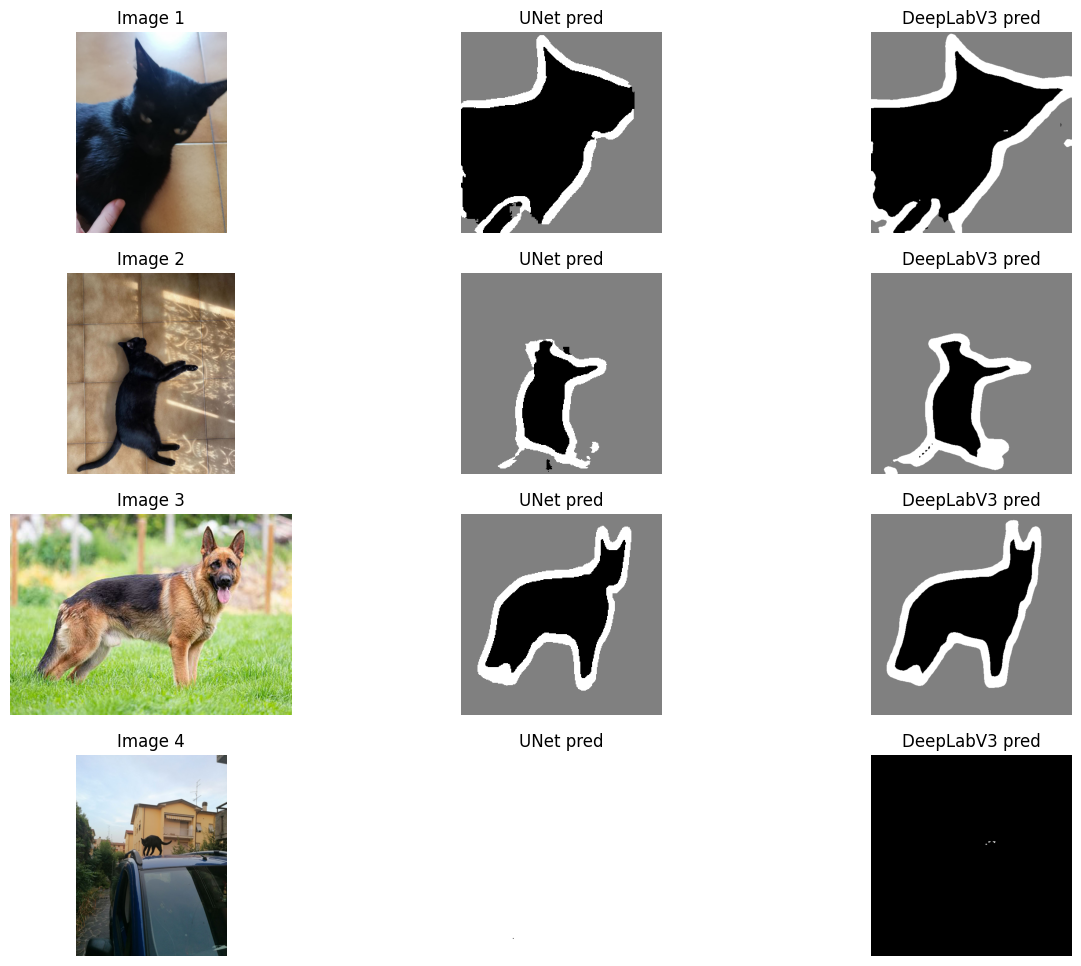

In [2]:
images1 = ['./wild_pet.jpg', './wild_pet2.jpg', './wild_pet3.jpg', './wild_pet_small.jpg']
view_pred(images1)

### That happens if more than on animal is in one image? How does the model perform?

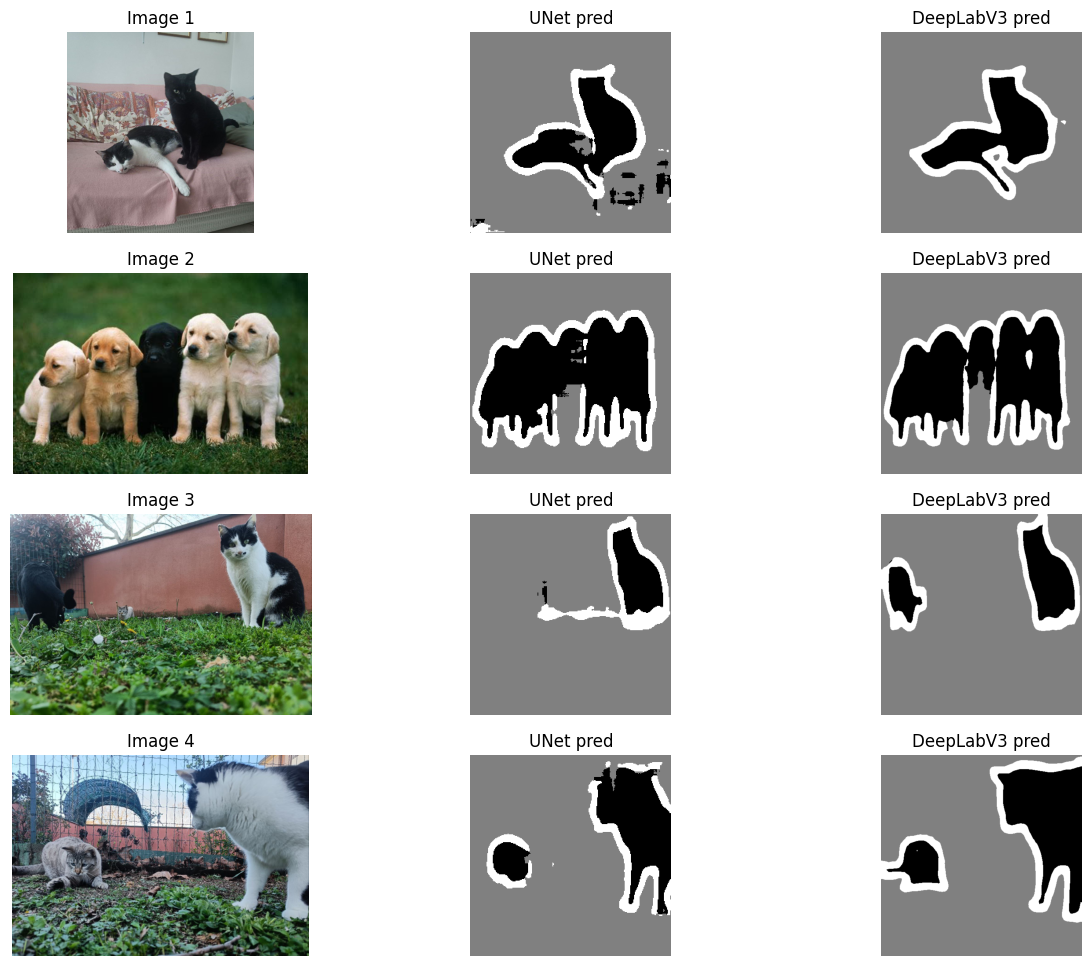

In [3]:

images2 = ['./wild_pets_close.jpg', './wild_pets_close2.jpg', './wild_pets_far.jpg', './wild_pets_far2.jpg']
view_pred(images2)